In [6]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import iplot , plot
from plotly.offline import init_notebook_mode
init_notebook_mode()
import plotly.io as pio
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler , LabelEncoder
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import  ConfusionMatrixDisplay, classification_report
import warnings
warnings.filterwarnings('ignore')

In [7]:
df = pd.read_csv('/Users/taz/Heart-Failure-Prediction/data/heart.csv')
print(f"Number of Row : {df.shape[0]}\nNumber of Columns : {df.shape[1]}")

df.describe()

Number of Row : 918
Number of Columns : 12


Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  918.000000  918.000000   918.000000  918.000000  918.000000   
mean    53.510893  132.396514   198.799564    0.233115  136.809368   
std      9.432617   18.514154   109.384145    0.423046   25.460334   
min     28.000000    0.000000     0.000000    0.000000   60.000000   
25%     47.000000  120.000000   173.250000    0.000000  120.000000   
50%     54.000000  130.000000   223.000000    0.000000  138.000000   
75%     60.000000  140.000000   267.000000    0.000000  156.000000   
max     77.000000  200.000000   603.000000    1.000000  202.000000   

          Oldpeak  HeartDisease  
count  918.000000    918.000000  
mean     0.887364      0.553377  
std      1.066570      0.497414  
min     -2.600000      0.000000  
25%      0.000000      0.000000  
50%      0.600000      1.000000  
75%      1.500000      1.000000  
max      6.200000      1.000000

- The data indicates that there are minimum values of 0 for the RestingBP and Cholesterol which are erroneous so we will correct for these values
- The data indicates that the minimum Oldpeak value is -2.6 which can be erroneous because ST depression (Oldpeak) of greater than 2 indicates a serious heart problem such as myocardial ischemia (i.e., lack of blood flow to heart), infarction (i.e., heart attack), or hypokalemia (i.e., low potassium levels in blood leading to arrhythmia or vetricular fibrillation)

In [8]:
#Checking for null values
print("Null Values in the dataset:\n", df.isnull().sum())
pd.DataFrame({'Count':df.shape[0],
              'Null':df.isnull().sum(),
              'Null %':df.isnull().mean() * 100,
              'Cardinality':df.nunique()
})

Null Values in the dataset:
 Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


Count  Null  Null %  Cardinality
Age               918     0     0.0           50
Sex               918     0     0.0            2
ChestPainType     918     0     0.0            4
RestingBP         918     0     0.0           67
Cholesterol       918     0     0.0          222
FastingBS         918     0     0.0            2
RestingECG        918     0     0.0            3
MaxHR             918     0     0.0          119
ExerciseAngina    918     0     0.0            2
Oldpeak           918     0     0.0           53
ST_Slope          918     0     0.0            3
HeartDisease      918     0     0.0            2

In [9]:
#Create dataframe for erroneous values
df[['RestingBP','Cholesterol']] = df[['RestingBP','Cholesterol']].replace(0,np.nan)

# Show Number of Missing Values (NaN)
df[['RestingBP','Cholesterol']].isna().sum()

RestingBP        1
Cholesterol    172
dtype: int64

In [10]:
# Show datapoint where NaN in RestingBP
df[df['RestingBP'].isna()]


Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
449   55   M           NAP        NaN          NaN          0     Normal   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
449    155              N      1.5     Flat             1

In [11]:
# Fill missing values in RestingBP with median based on HeartDisease
df['RestingBP'] = df['RestingBP'].fillna(df.groupby('HeartDisease')['RestingBP'].median()[1])

In [12]:
temp = df.groupby('HeartDisease')['Cholesterol'].median()
df.loc[(df['Cholesterol'].isna()) & (df['HeartDisease'] == 0), 'Cholesterol'] = temp[0]
df.loc[(df['Cholesterol'].isna()) & (df['HeartDisease'] == 1), 'Cholesterol'] = temp[1]

In [13]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [14]:
# Detecting outliers using IQR method

# Function to detect outliers using IQR method
def detect_outliers_iqr(df, columns, threshold = 1.5):

    outlier_indices = {}

    for col in columns:
        Q1 = df[col].quantile(0.25)  # 25th percentile
        Q3 = df[col].quantile(0.75)  # 75th percentile
        IQR = Q3 - Q1  # Interquartile range
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        # Check for outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index.tolist()
        outlier_indices[col] = outliers
    
    return outlier_indices

numerical_columns = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
outliers_iqr = detect_outliers_iqr(df, numerical_columns)

for col, indices in outliers_iqr.items():
    print(f"{col}: {len(indices)} outliers detected")


Age: 0 outliers detected
RestingBP: 27 outliers detected
Cholesterol: 41 outliers detected
MaxHR: 2 outliers detected
Oldpeak: 16 outliers detected


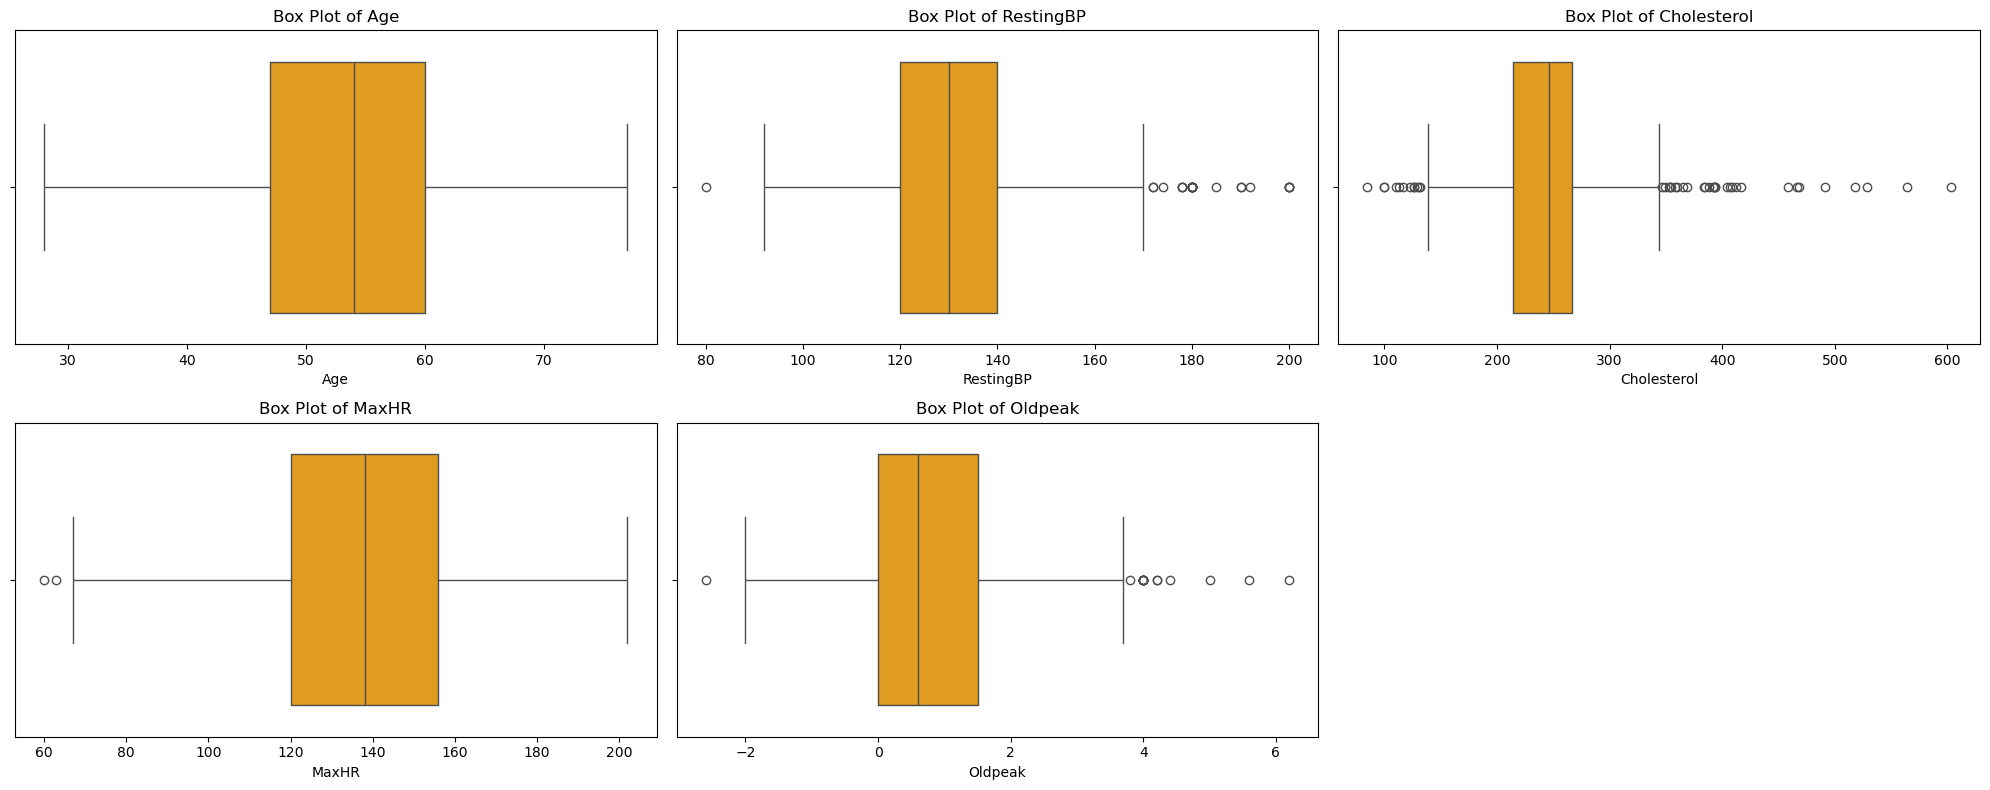

In [15]:
# Visualizing Outliers using Box Plots
plt.figure(figsize=(20, 8))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)  
    sns.boxplot(x = df[col], color = "orange")
    plt.title(f"Box Plot of {col}")

plt.tight_layout() 
plt.show()

In [ ]:
# Removing outliers based on IQR method
def remove_outliers(df, columns, threshold=1.5):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)  # First quartile (25%)
        Q3 = df_clean[col].quantile(0.75)  # Third quartile (75%)
        IQR = Q3 - Q1  # Interquartile range
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        df_clean = df_clean[(df_clean[col] > lower_bound) & (df_clean[col] < upper_bound)]
    
    return df_clean

df_cleaned = remove_outliers(df, numerical_columns)

print(f"Number of Row : {df_cleaned.shape[0]}\nNumber of Columns : {df_cleaned.shape[1]}")

Number of Row : 823
Number of Columns : 12


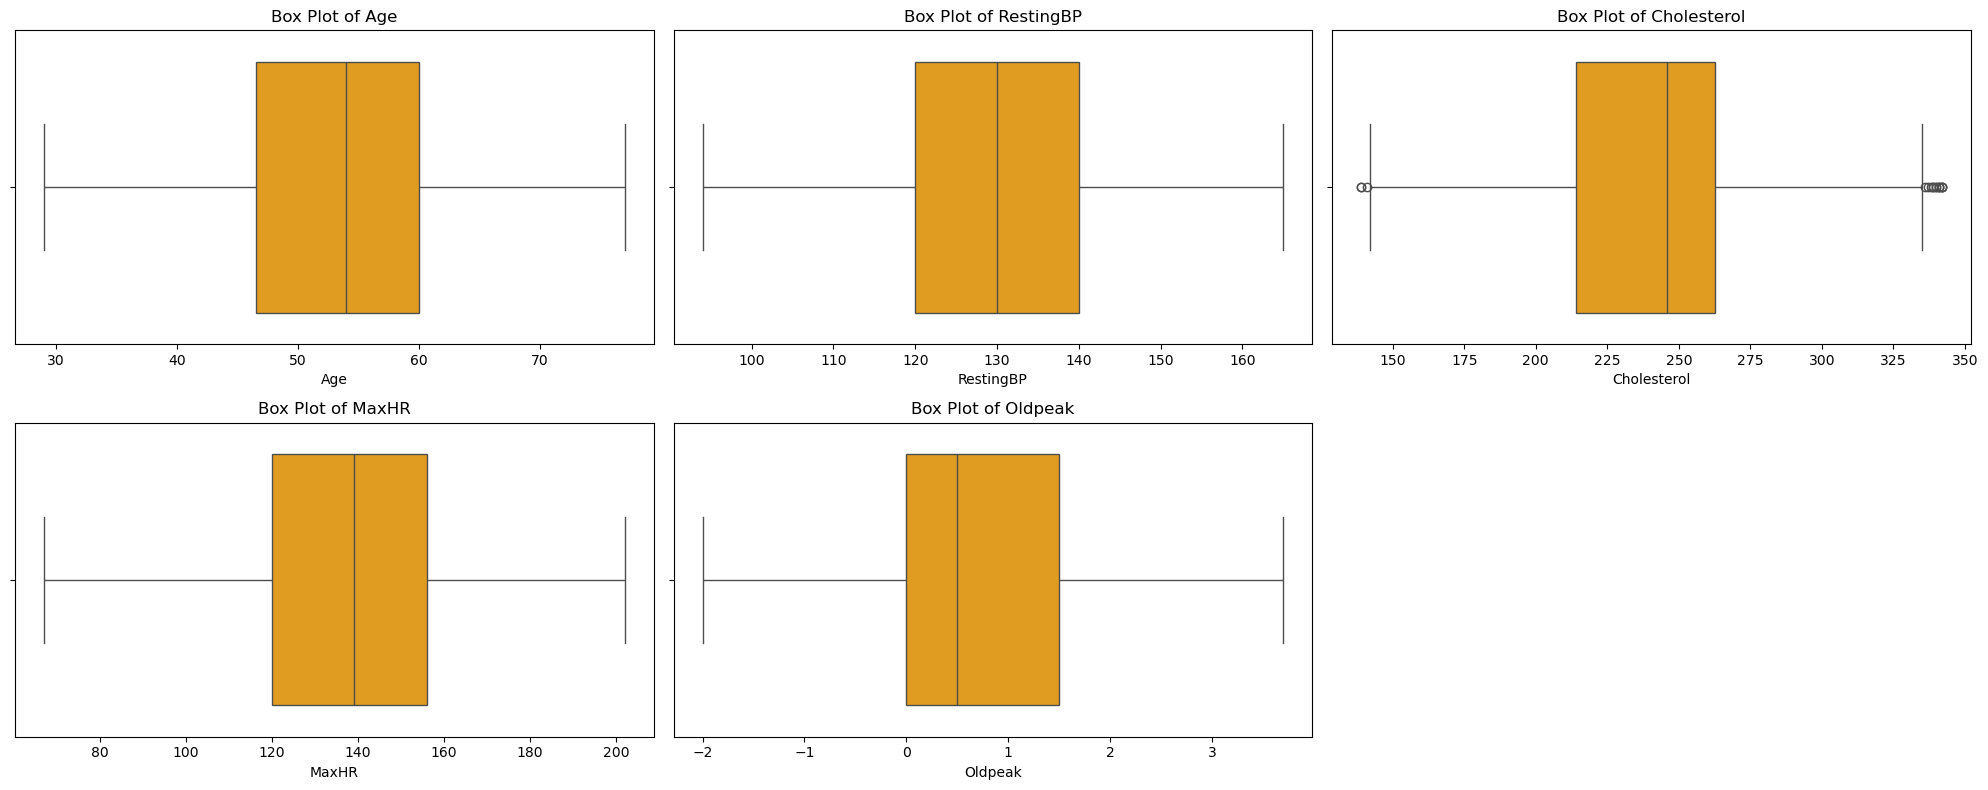

In [ ]:
# Visualizing Outliers after Removal using Box Plots
plt.figure(figsize=(20, 8))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i) 
    sns.boxplot(x = df_cleaned[col], color = "orange")
    plt.title(f"Box Plot of {col}")

plt.tight_layout()
plt.show()

In [18]:
df_cleaned.reset_index(inplace = True , drop = True)
df_cleaned.sample(5)

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
407   58   M           ASY      136.0        203.0          1     Normal   
456   58   M           ASY      110.0        198.0          0     Normal   
523   37   M           NAP      118.0        240.0          0        LVH   
447   62   M           ASY      135.0        297.0          0     Normal   
377   66   M           NAP      120.0        231.5          0         ST   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
407    123              Y      1.2     Flat             1  
456    110              N      0.0     Flat             1  
523    165              N      1.0     Flat             0  
447    130              Y      1.0     Flat             1  
377    120              N     -0.5       Up             0

In [19]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823 entries, 0 to 822
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             823 non-null    int64  
 1   Sex             823 non-null    object 
 2   ChestPainType   823 non-null    object 
 3   RestingBP       823 non-null    float64
 4   Cholesterol     823 non-null    float64
 5   FastingBS       823 non-null    int64  
 6   RestingECG      823 non-null    object 
 7   MaxHR           823 non-null    int64  
 8   ExerciseAngina  823 non-null    object 
 9   Oldpeak         823 non-null    float64
 10  ST_Slope        823 non-null    object 
 11  HeartDisease    823 non-null    int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 77.3+ KB


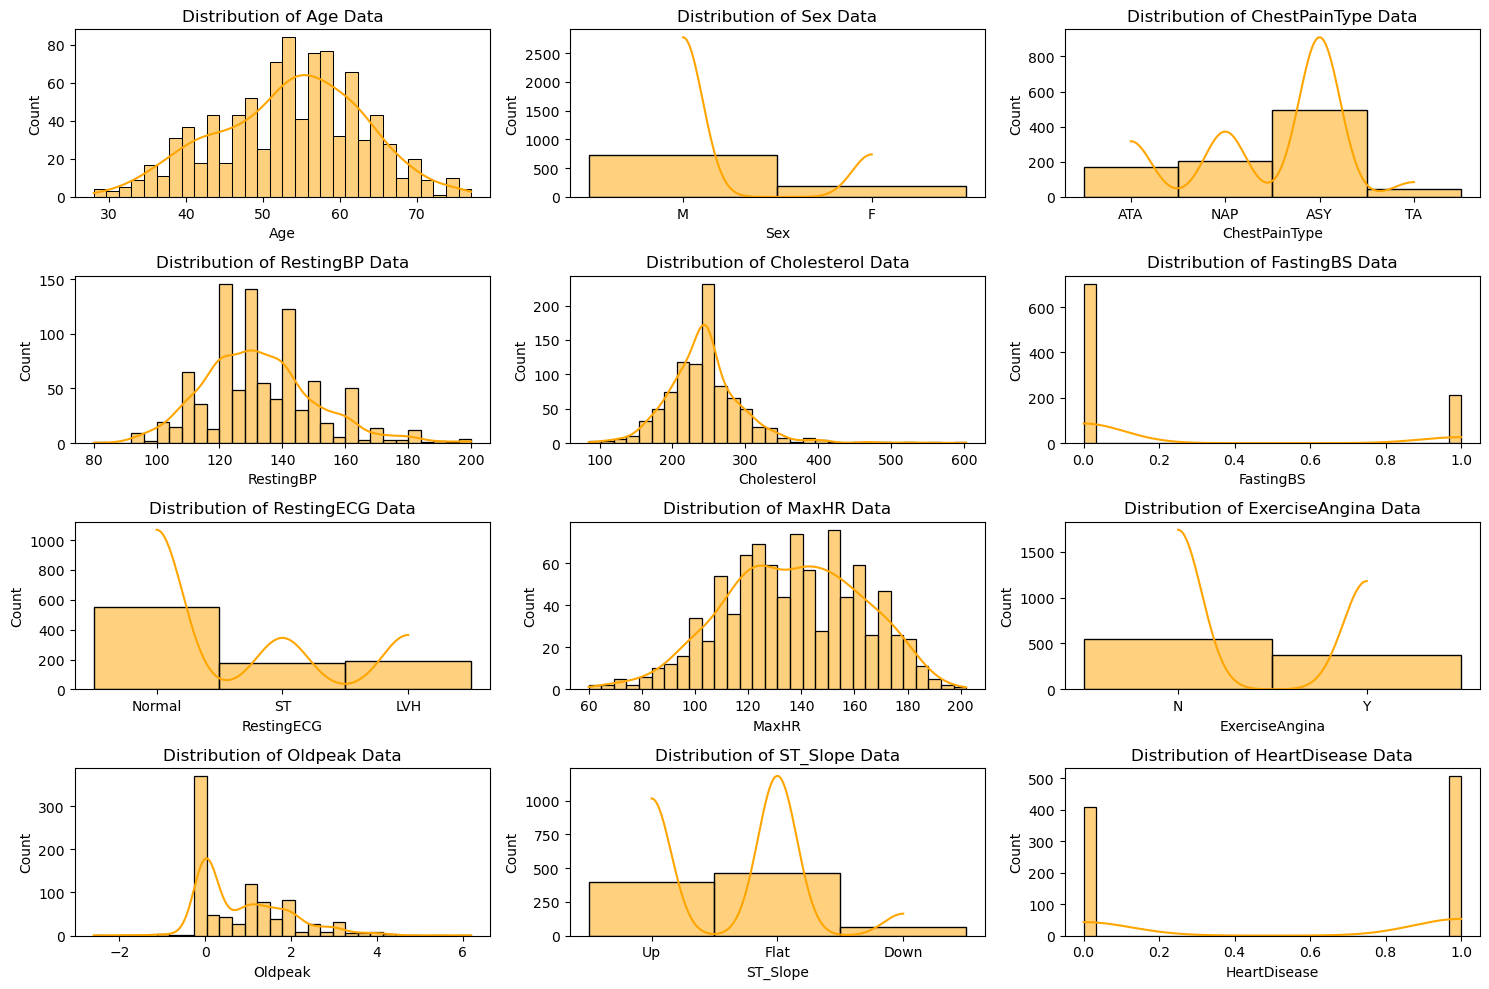

In [ ]:
# Visualizing the distribution of each feature in the dataset
plt.figure(figsize=(15,10))
for i,col in enumerate(df.columns,1):
    plt.subplot(4,3,i)
    plt.title(f"Distribution of {col} Data")
    sns.histplot(df[col],kde=True, color='orange', bins=30)
    plt.tight_layout()
    plt.plot()

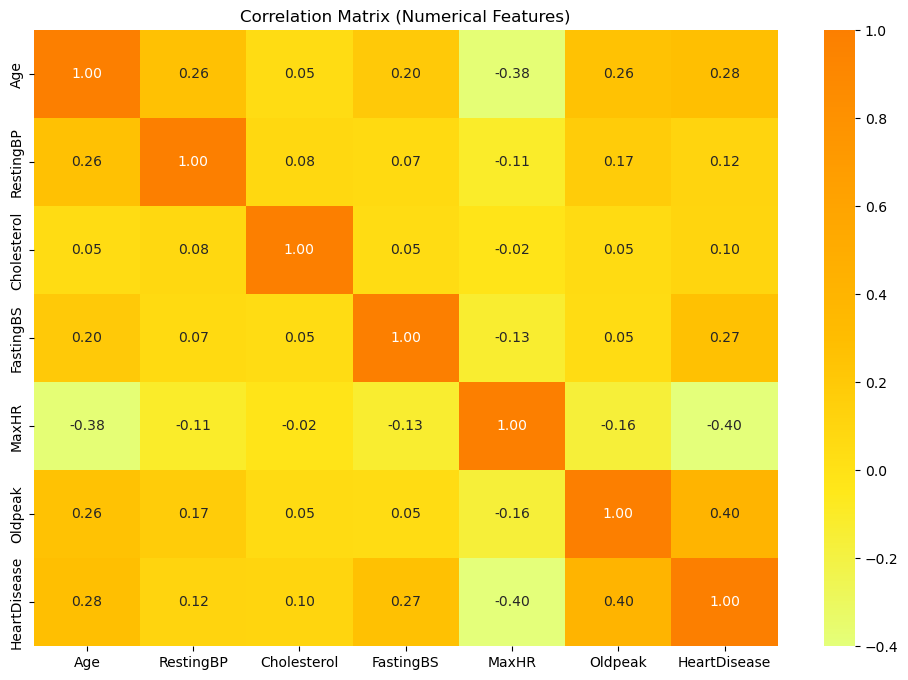

In [35]:
# Visualizing the correlation matrix of numerical features
plt.figure(figsize=(12,8))
numerical_columns = df_cleaned.select_dtypes(include=['int64', 'float64']).columns
corr = df[numerical_columns].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="Wistia")
plt.title("Correlation Matrix (Numerical Features)")
plt.show()

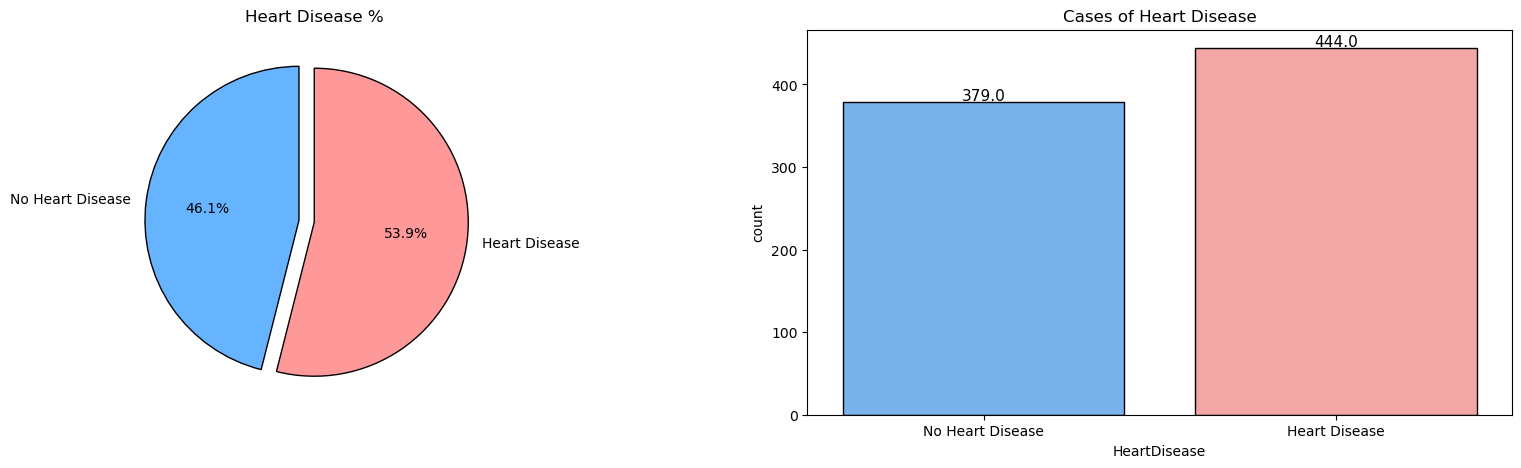

In [48]:
hd_list = list(df_cleaned['HeartDisease'].value_counts())
circle = [hd_list[1] / sum(hd_list) * 100,hd_list[0] / sum(hd_list) * 100]

fig,ax = plt.subplots(nrows = 1,ncols = 2,figsize = (20,5))
plt.subplot(1,2,1)
plt.pie(circle,labels = ['No Heart Disease','Heart Disease'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0),colors= ['#66b3ff', '#ff9999'],
        wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('Heart Disease %');

plt.subplot(1,2,2)
ax = sns.countplot(x='HeartDisease',data=df_cleaned, palette = ['#66b3ff', '#ff9999'],edgecolor = 'black')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
ax.set_xticklabels(['No Heart Disease','Heart Disease'])
plt.title('Cases of Heart Disease');
plt.show()

In [53]:
col = list(df_cleaned.columns)
categorical_features = []
numerical_features = []
for i in col:
    if len(df_cleaned[i].unique()) > 6:
        numerical_features.append(i)
    else:
        categorical_features.append(i)

print('Categorical Features : ',*categorical_features)
print('Numerical Features :',*numerical_features)

Categorical Features :  Sex ChestPainType FastingBS RestingECG ExerciseAngina ST_Slope HeartDisease
Numerical Features : Age RestingBP Cholesterol MaxHR Oldpeak


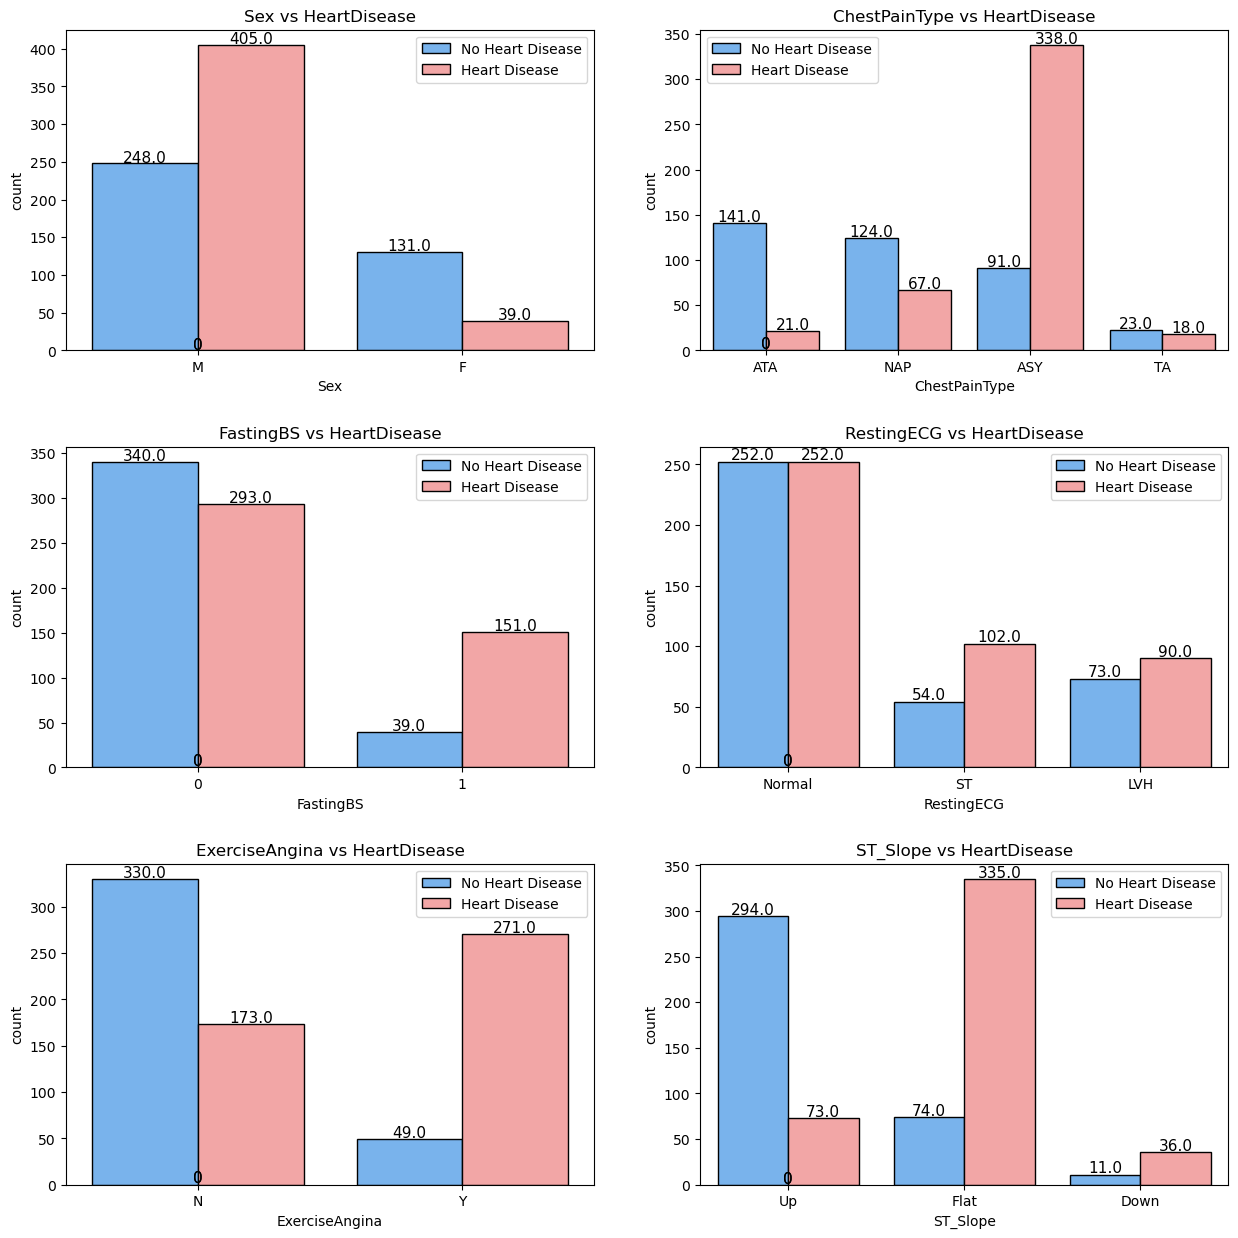

In [89]:
fig, ax = plt.subplots(nrows = 3,ncols = 2,figsize = (15,15))
plt.subplots_adjust(hspace=0.3)
for i in range(len(categorical_features) - 1):
    plt.subplot(3,2,i+1)
    ax = sns.countplot(x=categorical_features[i],data = df_cleaned,hue = "HeartDisease",palette = ['#66b3ff', '#ff9999'],edgecolor = 'black')
    for rect in ax.patches:
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
    title = categorical_features[i] + ' vs HeartDisease'
    plt.legend(['No Heart Disease','Heart Disease'])
    plt.title(title)

Observations:

- Among males, the number of heart disease patients is higher than those without. Conversely, in the female population, there are more individuals without heart disease than with it.

- The presence of asymptomatic (ASY) chest pain is strongly associated with a higher likelihood of heart disease.

- Fasting blood sugar levels are not definitive indicators—patients with both elevated and normal fasting blood sugar levels show notable cases of heart disease.

- Resting ECG results do not provide a clear distinction; all three categories exhibit a substantial number of heart disease cases.

- The presence of exercise-induced angina significantly increases the probability of heart disease diagnosis.

- A flat ST_Slope slope is highly indicative of heart disease. A downward slope also correlates with heart disease, though it appears in fewer cases.

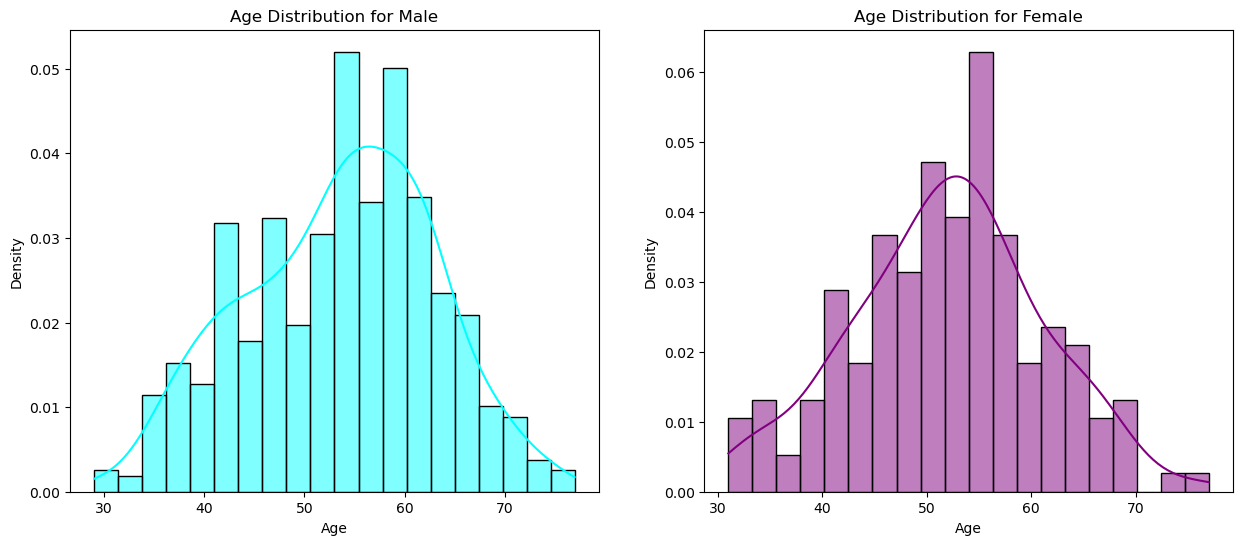

Higher prevalence of individuals in the age group of 50-60 years


In [21]:
#Age Distribution between Sexes
plt.figure(figsize=(15, 6))

plt.subplot(1,2,1)

sns.histplot(df_cleaned[df['Sex'] == 'M']['Age'], color='cyan', kde=True, bins=20, stat='density')
plt.title('Age Distribution for Male')

plt.subplot(1,2,2)

sns.histplot(df_cleaned[df['Sex'] == 'F']['Age'], color='purple', kde=True, bins=20, stat='density')
plt.title('Age Distribution for Female')

plt.show()
print("Higher prevalence of individuals in the age group of 50-60 years") 

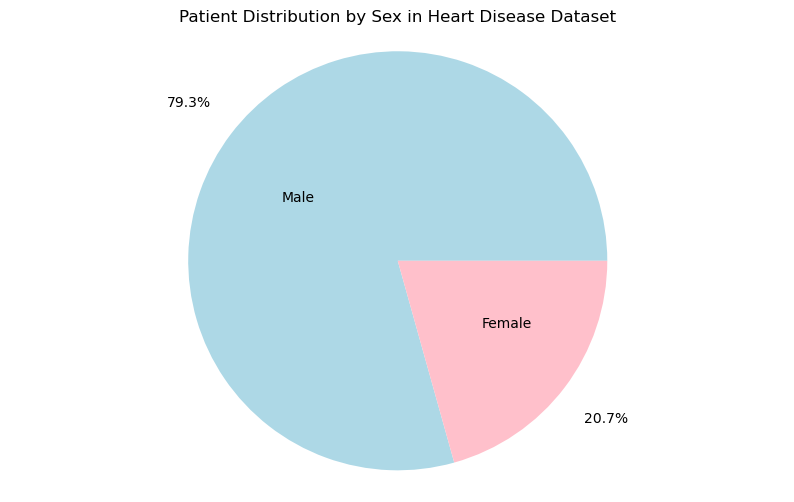

In [ ]:
# Pie chart for Patient Distribution by Sex
plt.figure(figsize=(10, 6))
plt.pie(df_cleaned['Sex'].value_counts(),
        labels=['Male','Female'],
        autopct='%1.1f%%',
        colors=['lightblue', 'pink'],
        startangle=0,
        pctdistance=1.25, labeldistance=0.5)

plt.title('Patient Distribution by Sex in Heart Disease Dataset')
plt.axis('equal')  
plt.show()

In [ ]:
# Data set up for pie charts
fbs = df_cleaned[df_cleaned['HeartDisease'] == 1]['FastingBS'].value_counts()
fbs = [fbs[0] / sum(fbs) * 100,fbs[1] / sum(fbs) * 100]

restecg = df_cleaned[df_cleaned['HeartDisease'] == 1]['RestingECG'].value_counts()
restecg = [restecg[0] / sum(restecg) * 100,restecg[1] / sum(restecg) * 100,restecg[2] / sum(restecg) * 100]

exang = df_cleaned[df_cleaned['HeartDisease'] == 1]['ExerciseAngina'].value_counts()
exang = [exang[0] / sum(exang) * 100,exang[1] / sum(exang) * 100]

slope = df_cleaned[df_cleaned['HeartDisease'] == 1]['ST_Slope'].value_counts()
slope = [slope[0] / sum(slope) * 100,slope[1] / sum(slope) * 100,slope[2] / sum(slope) * 100]

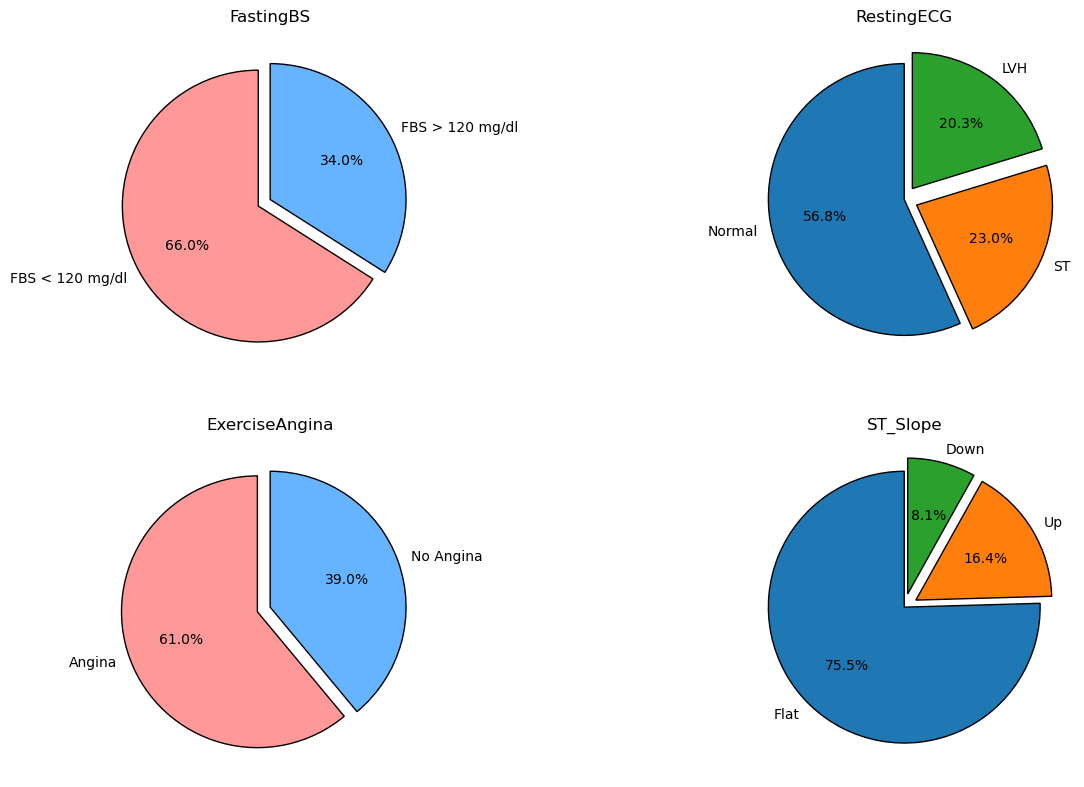

In [ ]:
# Plotting pie charts for categorical features
ax,fig = plt.subplots(nrows = 2,ncols = 2,figsize = (15,15))

plt.subplot(3,2,3)
plt.pie(fbs,labels = ['FBS < 120 mg/dl','FBS > 120 mg/dl'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0),colors = ['#ff9999', '#66b3ff'],
        wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('FastingBS');

plt.subplot(3,2,4)
plt.pie(restecg,labels = ['Normal','ST','LVH'],autopct='%1.1f%%',startangle = 90,explode = (0,0.1,0.1),
        wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('RestingECG');

plt.subplot(3,2,5)
plt.pie(exang,labels = ['Angina','No Angina'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0),colors = ['#ff9999', '#66b3ff'],
        wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('ExerciseAngina');

plt.subplot(3,2,6)
plt.pie(slope,labels = ['Flat','Up','Down'],autopct='%1.1f%%',startangle = 90,explode = (0,0.1,0.1),
        wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('ST_Slope');

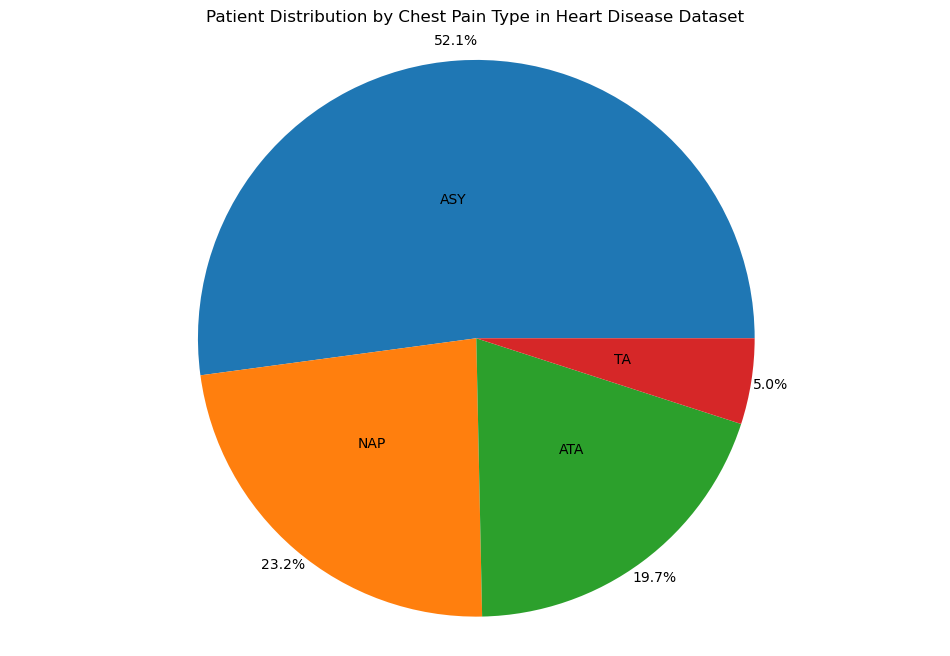

In [ ]:
# Pie chart for Patient Distribution by Chest Pain Type
plt.figure(figsize=(12, 8))
plt.pie(df_cleaned['ChestPainType'].value_counts(),
        labels=['ASY','NAP','ATA','TA'],
        autopct='%1.1f%%',
        startangle=0,
        pctdistance=1.07, labeldistance=0.5)

plt.title('Patient Distribution by Chest Pain Type in Heart Disease Dataset')
plt.axis('equal')  
plt.show()

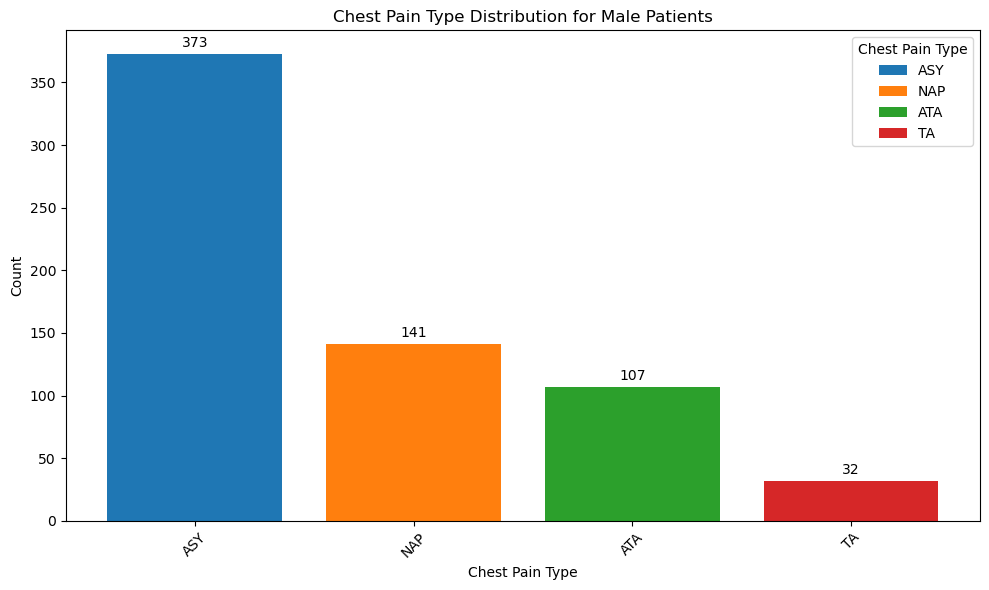

In [ ]:
# Bar chart for Chest Pain Type Distribution for Male Patients
male_chest_pain_type = df_cleaned[df_cleaned['Sex'] == 'M']['ChestPainType'].value_counts().index
male_chest_pain_counts = df_cleaned[df_cleaned['Sex'] == 'M']['ChestPainType'].value_counts()

fig, ax = plt.subplots(figsize=(10, 6))
for i, category in enumerate(male_chest_pain_type):
    ax.bar(category, male_chest_pain_counts[i], label=category)

for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10, padding=3)


ax.set_title('Chest Pain Type Distribution for Male Patients')
ax.set_xlabel('Chest Pain Type')
ax.set_ylabel('Count')
ax.legend(title='Chest Pain Type', loc='upper right')
ax.grid(False)
plt.xticks(rotation=45)
plt.tight_layout()

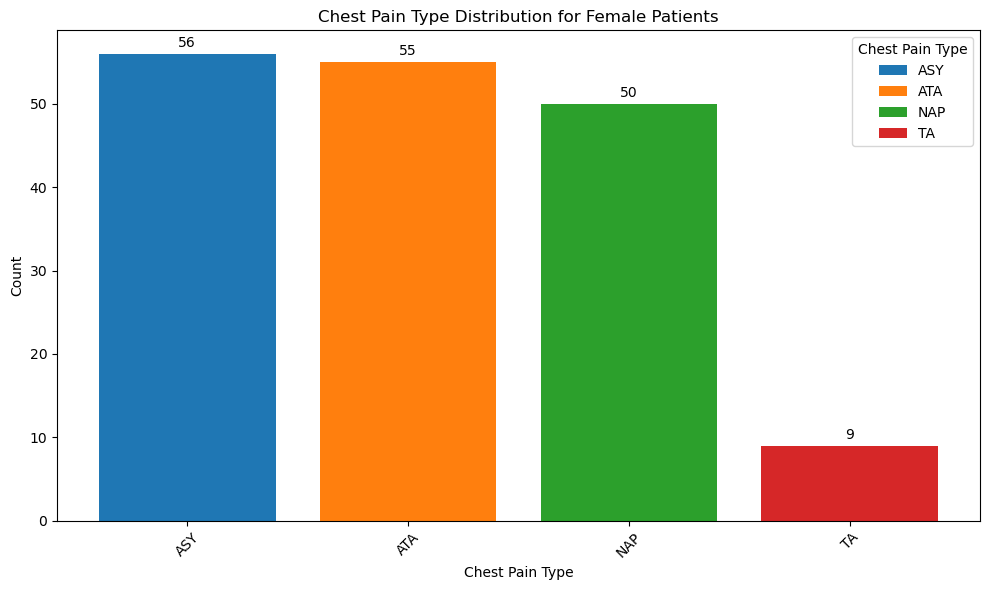

In [ ]:
# Bar chart for Chest Pain Type Distribution for Female Patients
female_chest_pain_type = df_cleaned[df_cleaned['Sex'] == 'F']['ChestPainType'].value_counts().index
female_chest_pain_counts = df_cleaned[df_cleaned['Sex'] == 'F']['ChestPainType'].value_counts()

fig, ax2 = plt.subplots(figsize=(10, 6))
for i, category in enumerate(female_chest_pain_type):
    ax2.bar(category, female_chest_pain_counts[i], label=category)

for container in ax2.containers:
    ax2.bar_label(container, label_type='edge', fontsize=10, padding=3)


ax2.set_title('Chest Pain Type Distribution for Female Patients')
ax2.set_xlabel('Chest Pain Type')
ax2.set_ylabel('Count')
ax2.legend(title='Chest Pain Type', loc='upper right')
ax2.grid(False)
plt.xticks(rotation=45)
plt.tight_layout()

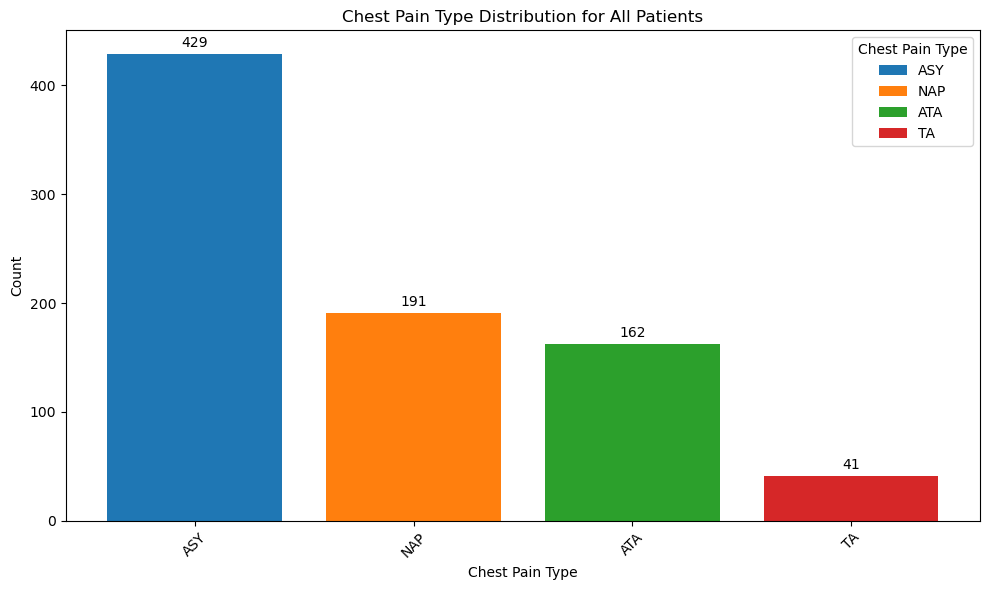

In [ ]:
# Bar chart for Chest Pain Type Distribution for All Patients
chest_pain_type = df_cleaned['ChestPainType'].value_counts().index
chest_pain_counts = df_cleaned['ChestPainType'].value_counts()

fig, ax3 = plt.subplots(figsize=(10, 6))
for i, category in enumerate(chest_pain_type):
    ax3.bar(category, chest_pain_counts[i], label=category)

for container in ax3.containers:
    ax3.bar_label(container, label_type='edge', fontsize=10, padding=3)


ax3.set_title('Chest Pain Type Distribution for All Patients')
ax3.set_xlabel('Chest Pain Type')
ax3.set_ylabel('Count')
ax3.legend(title='Chest Pain Type', loc='upper right')
ax3.grid(False)
plt.xticks(rotation=45)
plt.tight_layout()

Observations:

- Approximately 80% of heart disease patients are male, indicating a significant gender disparity.

- Asymptomatic (ASY) chest pain is the most common among heart disease cases, accounting for 52% of patients.

- Fasting blood sugar levels below 120 mg/dL are frequently observed in heart disease patients, suggesting a notable correlation.

- Among Resting ECG results, the "Normal" category represents 56% of heart disease cases—more than Left Ventricular Hypertrophy (LVH) or ST-T wave abnormalities.

- The presence of exercise-induced angina is a strong indicator of potential heart disease.

- A flat ST slope is present in 75% of heart disease cases, making it a valuable marker for identifying underlying cardiac issues.

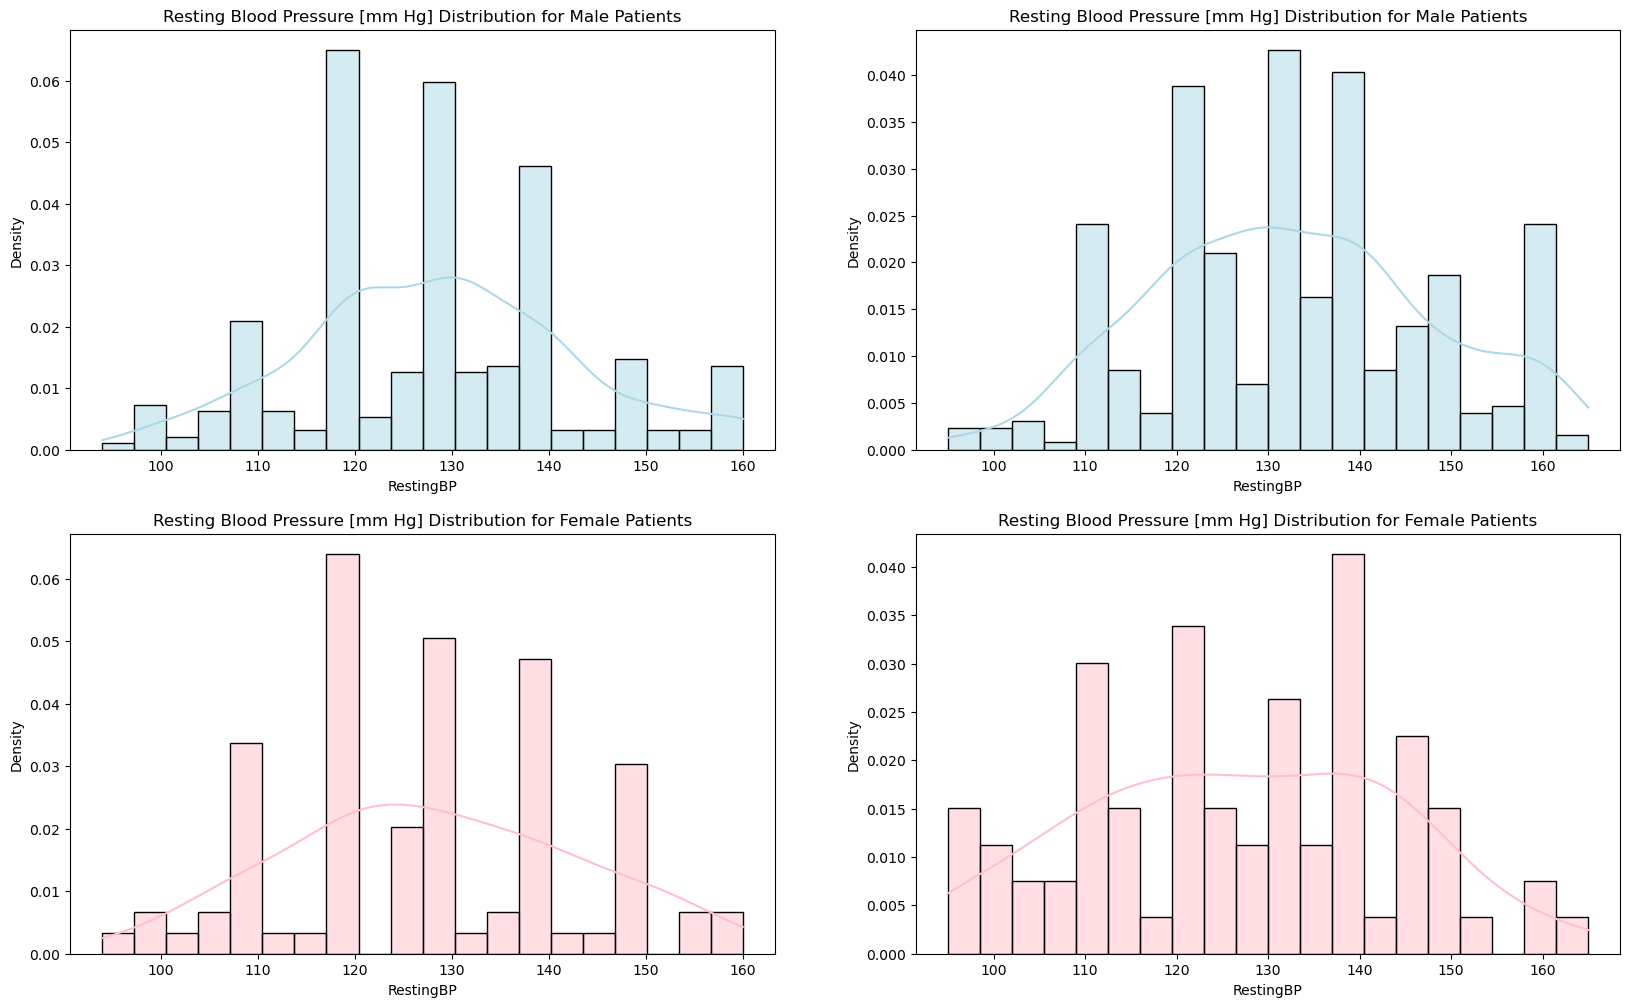

In [ ]:
# Visualizing Resting Blood Pressure
plt.figure(figsize=(20, 12))

plt.subplot(2,2,1)

sns.histplot(df_cleaned[(df['Sex'] == 'M') & (df_cleaned['HeartDisease'] == 0)]['RestingBP'], color='lightblue', kde=True, bins=20, stat='density')
plt.title('Resting Blood Pressure [mm Hg] Distribution for Male Patients')
plt.grid(False)

plt.subplot(2,2,2)

sns.histplot(df_cleaned[(df['Sex'] == 'M') & (df_cleaned['HeartDisease'] == 1)]['RestingBP'], color='lightblue', kde=True, bins=20, stat='density')
plt.title('Resting Blood Pressure [mm Hg] Distribution for Male Patients')
plt.grid(False)

plt.subplot(2,2,3)

sns.histplot(df_cleaned[(df['Sex'] == 'F') & (df_cleaned['HeartDisease'] == 0)]['RestingBP'], color='pink', kde=True, bins=20, stat='density')
plt.title('Resting Blood Pressure [mm Hg] Distribution for Female Patients')
plt.grid(False)

plt.subplot(2,2,4)

sns.histplot(df_cleaned[(df['Sex'] == 'F') & (df_cleaned['HeartDisease'] == 1)]['RestingBP'], color='pink', kde=True, bins=20, stat='density')
plt.title('Resting Blood Pressure [mm Hg] Distribution for Female Patients')
plt.grid(False)
plt.show()

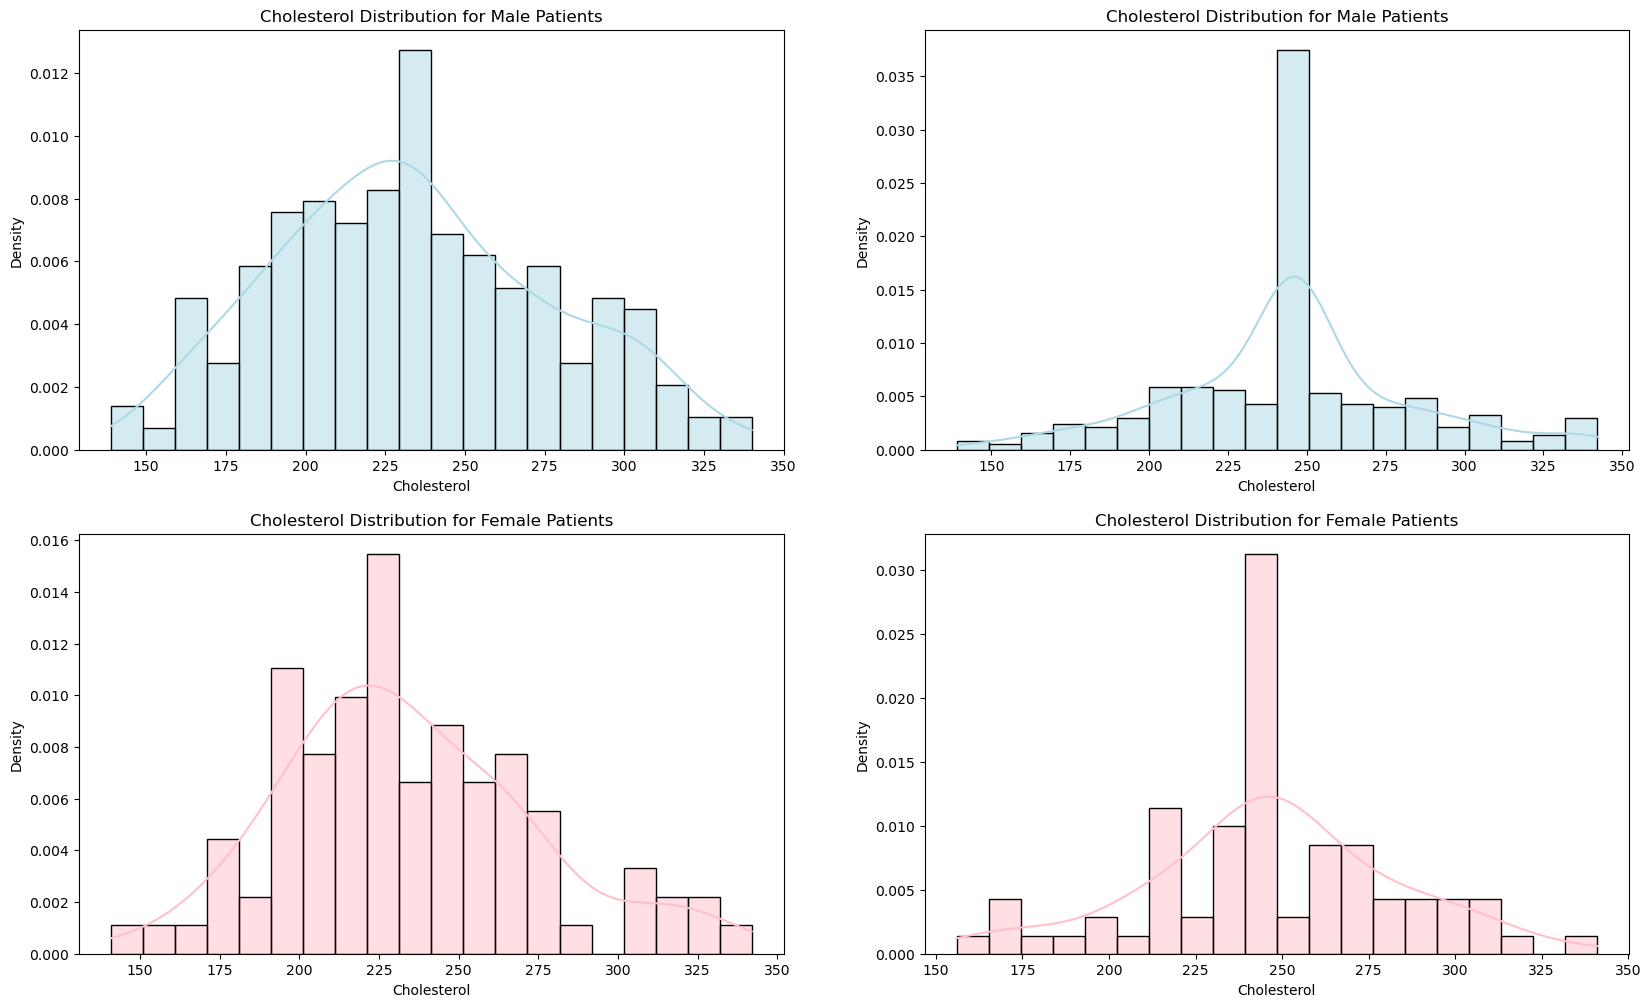

In [ ]:
# Visualizing Cholesterol Levels
plt.figure(figsize=(20, 12))

plt.subplot(2,2,1)

sns.histplot(df_cleaned[(df['Sex'] == 'M') & (df_cleaned['HeartDisease'] == 0)]['Cholesterol'], color='lightblue', kde=True, bins=20, stat='density')
plt.title('Cholesterol Distribution for Male Patients')
plt.grid(False)

plt.subplot(2,2,2)

sns.histplot(df_cleaned[(df['Sex'] == 'M') & (df_cleaned['HeartDisease'] == 1)]['Cholesterol'], color='lightblue', kde=True, bins=20, stat='density')
plt.title('Cholesterol Distribution for Male Patients')
plt.grid(False)

plt.subplot(2,2,3)

sns.histplot(df_cleaned[(df['Sex'] == 'F') & (df_cleaned['HeartDisease'] == 0)]['Cholesterol'], color='pink', kde=True, bins=20, stat='density')
plt.title('Cholesterol Distribution for Female Patients')
plt.grid(False)

plt.subplot(2,2,4)

sns.histplot(df_cleaned[(df['Sex'] == 'F') & (df_cleaned['HeartDisease'] == 1)]['Cholesterol'], color='pink', kde=True, bins=20, stat='density')
plt.title('Cholesterol Distribution for Female Patients')
plt.grid(False)
plt.show()